#### 텍스트요약은 크게 두가지로 나뉜다.<br>

1. 추출적 요약(Extractive Summarization)<br>
2. 추상적 요약(Abstractive Summarization)

#### 1. 추출적 요약 (머신러닝, TextRank)

- 원문에서 문장들을 추출해서 요약하는 방식<br>ex) 10개의 문장으로 구성된 텍스트가 있을 때, 그중 핵심적인 문장 3개를 꺼내와서 3개의 문장으로 구성된 요약문을 만드는 것.<br><br>
- 원문의 문장중 어느 것이 요약문에 들어갈 핵심문장일지 판별하는 `문장 분류(Text Classification)`<br><br>
- 단점 : 결과로 나온 문장들 간의 호응이 자연스럽지 않을 수 있음.

#### 2. 추상적 요약
- 원문으로부터 내용이 요약된 **새로운 문장을 생성**해내는 것.<br>
- 자연어 처리 분야 중 `자연어 생성(Natural Language Generation, NLG)` 영역임.

<br> 

#### 구글의 seq2seq() 모델

- 두개의 RNN 아키텍처를 사용해서 입력 시퀀스로부터 출력 시퀀스를 생성해 내는 자연어 생성 모델.<br><br>
- 원문을 첫 번째 RNN인 인코더로 입력, 인코더는 이를 하나의 고정된 벡터로 변환 (= **컨텍스트 벡터(Context Vector) 문맥)**
- 두번째 RNN 디코더는 이 컨텍스트 벡터를 전달받아 한 단어씩 생성해내는 요약 문장을 완성

### 오늘의 데이터 : 아마존 리뷰 데이터셋

- 이번 실습에서는 NLTK의 불용어(stopwords)를 사용한다.<br>NLTK와 NLTK 데이터셋이 설치되어 있지 않은 환경이라면 우선 설치해보자.

- NLTK : Natural Language Toolkit의 약자 --> 영어 기호, 통계 자연어처리를 위한 라이브러리
- NLTK에는 I, my, me, over, 조사, 저버미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는데는 거의 의미가 없는<br>100여개의 불용어가 미리 정의되어 있다.

In [14]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data = pd.read_csv(os.getenv('HOME')+'/aiffel/news_summarization/data/Reviews.csv', nrows=100000)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [16]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [17]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [18]:
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [19]:
# 랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
34701,Earl Grey is one of my favorite blends of tea....,Does Not Taste Like Earl Grey To Me
22618,"I've had Teavana, Mighty Leaf and many other g...","Rich, luscious and smooth, very leafy (not ste..."
26228,I've tried many of the various coffee sticks o...,Great Taste
79539,I saw people here complaining that the formula...,New and NOT Improved
7943,This stuff is gold for the hot/spicy food enth...,Simply amazing...
13553,To those who believe these Onion Rings doesn't...,Funyuns? Certainly no but BETTER
94159,If I buy this dog food in the store it will co...,Chick Soup for the Dob Lovers Soul
36796,I am really happy I went ahead and ordered thi...,No complaints here!
66126,Excellent trainning treats. My dogs love them ...,Great for trainning
92401,This product had earlier gotten mixed reviews ...,A great brew


<br>

### 데이터 전처리하기 (1) 데이터 정리

<br>

**⭐ 중복 샘플과 NULL 값이 존재하는 샘플 제거<br>**

---

In [20]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


<br>`drop_duplicates()`를 사용하여 중복된 샘플 제거<br><br>

In [21]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다.
data.drop_duplicates(subset=['Text'], inplace=True)
print('전체 샘플수 :', len(data))

전체 샘플수 : 88426


In [22]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


<br>데이터프레임에서 Null을 제거할 때는  `dropna()`함수를 사용한다. <br><br>

In [23]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수 :', len(data))

전체 샘플 수 : 88425


<br><br>
**⭐ 텍스트 정규화와 불용어 제거**

---

- 살아남은 데이터 샘플 중 같은 의미인데 다른 표현으로 사용된 단어들이 존재한다.<br>ex) `it'll == it will`<br><br>
- 기계가 굳이 다른 단어로 다른 단어로 간주하게 해서 연산량을 늘리는 것보다 기계 학습전에 미리 같은 표현으로 통일시켜주자<br><br>
이러한 방법론 --> **텍스트 정규화(text normalization)**

In [24]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


<br>

- 정규화(text normalization)까지 마쳤어도, **불용어(stopwords)**라고 불리는 일반적으로 텍스트에 자주 등장하지만 자연어 처리할 때 실질적으로 도움이 되지 않는 단어들을 제거해야함.<br><br>
- NLTK 에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거해보자.<br><br>

In [25]:
print('불용어 갯수 :', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 갯수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

<br>+ 알파로, 모든 영어 문자는 소문자로, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리해야 함.<br><br>

In [26]:
# 데이터 전처리 함수

In [27]:
contractions["I'm"]

'I am'

In [29]:
' '.join([contractions[t] if t in contractions else t for t in "I'm a boy.".split(" ")])

'I am a boy.'

In [30]:
sentence = 'I my me mine you are so beautiful.'

In [31]:
tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
tokens

'mine beautiful.'

In [33]:
len(' ')

1

In [34]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href = ...>등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
    

In [35]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print('text :', preprocess_sentence(temp_text))
print('summary :', preprocess_sentence(temp_summary, False))

text : everything bought great infact ordered twice third ordered wasfor mother father
summary : great way to start the day


In [46]:
clean_text = []
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸리 수 있음.
for i, s in enumerate(data['Text']):
    clean_text.append(preprocess_sentence(s))
    if i % 1000 == 0:
        print(f"{100*i/len(data['Text'])}% 완료됨.")
    
# 전처리 후 출력
print('Text 전처리 후 결과 :', clean_text[:5])

0.0% 완료됨.
1.1309018942606728% 완료됨.
2.2618037885213456% 완료됨.
3.392705682782019% 완료됨.
4.523607577042691% 완료됨.
5.654509471303364% 완료됨.
6.785411365564038% 완료됨.
7.91631325982471% 완료됨.
9.047215154085382% 완료됨.
10.178117048346056% 완료됨.
11.309018942606729% 완료됨.
12.439920836867401% 완료됨.
13.570822731128075% 완료됨.
14.701724625388747% 완료됨.
15.83262651964942% 완료됨.
16.963528413910094% 완료됨.
18.094430308170764% 완료됨.
19.22533220243144% 완료됨.
20.356234096692113% 완료됨.
21.487135990952783% 완료됨.
22.618037885213457% 완료됨.
23.74893977947413% 완료됨.
24.879841673734802% 완료됨.
26.010743567995476% 완료됨.
27.14164546225615% 완료됨.
28.27254735651682% 완료됨.
29.403449250777495% 완료됨.
30.53435114503817% 완료됨.
31.66525303929884% 완료됨.
32.796154933559514% 완료됨.
33.92705682782019% 완료됨.
35.05795872208086% 완료됨.
36.18886061634153% 완료됨.
37.3197625106022% 완료됨.
38.45066440486288% 완료됨.
39.58156629912355% 완료됨.
40.712468193384225% 완료됨.
41.8433700876449% 완료됨.
42.97427198190557% 완료됨.
44.10517387616624% 완료됨.
45.236075770426915% 완료됨.
46.366977664687

In [47]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [52]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [53]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [54]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


<br>

### 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기

<br>

**⭐ 샘플의 최대 길이 정하기<br>**

---

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 볼게요.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


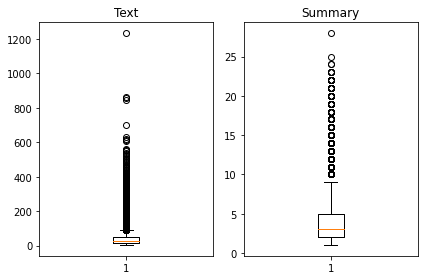

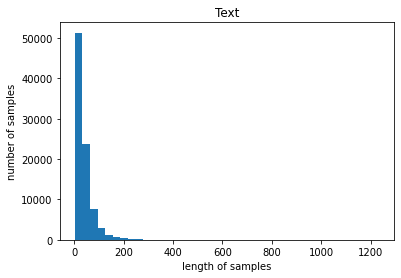

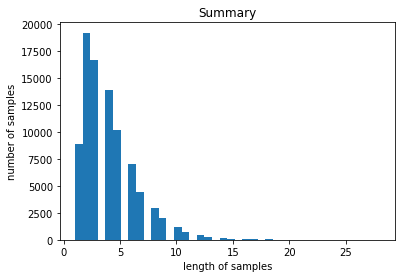

In [55]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [56]:
text_max_len = 50
summary_max_len = 8

In [57]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [58]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [67]:
# dd = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
# print('전체 샘플수 :', (len(dd)))

In [68]:
# gg = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
# print('전체 샘플수 :', (len(gg)))

In [61]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


<br>

**⭐ 시작 토큰과 종료 토큰 추가하기<br>**

---

In [62]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [66]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [93]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
indices

array([59919, 46093, 46456, ...,  8521, 55458, 42501])

In [94]:
# a = list(['a','b','c','d','e'])
# a = np.array(a)
# a

In [95]:
# idx = np.array([2,1,0,4,3])
# idx

In [96]:
# a[idx]

In [97]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [105]:
import math

n_of_val = int(len(encoder_input)*0.2)
print('트레인 데이터의 수 :', math.ceil(len(encoder_input)*0.8))
print('테스트 데이터의 수 :', n_of_val)

트레인 데이터의 수 : 52655
테스트 데이터의 수 : 13163


In [102]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


<br>

### 데이터 전처리하기 (3) 정수 인코딩

<br>

**⭐ 단어 집합(vocabulary) 만들기 및 정수 인코딩<br>**

---

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들로 모두 정수로 바꾸어 주어야 한다.<br> 이를 위해 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다.<br><br>이 과정을 단어 집합(vocabulary)을 만든다고 표현함.

In [109]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [113]:
# 생성된 단어 집합이 저장됬다. 
len(src_tokenizer.word_index)

32051

In [112]:
src_tokenizer.word_counts.items()

odict_items([('prompt', 110), ('professional', 35), ('service', 649), ('business', 174), ('company', 1032), ('jim', 26), ('love', 10359), ('flavor', 9775), ('spouse', 20), ('fond', 74), ('put', 1708), ('teaspoon', 110), ('sugar', 3197), ('mine', 413), ('hazelnut', 186), ('chocolate', 4357), ('powdered', 172), ('creamers', 46), ('get', 6497), ('right', 2232), ('taste', 11572), ('since', 2526), ('cannot', 3148), ('drink', 3210), ('coffee', 9795), ('straight', 221), ('strong', 2031), ('sell', 352), ('rice', 1430), ('expensive', 1355), ('amazon', 6069), ('lot', 2060), ('cheaper', 1031), ('chinese', 110), ('supermarket', 294), ('great', 14287), ('husband', 1309), ('bought', 3674), ('different', 1883), ('made', 2924), ('cappuccino', 101), ('espresso', 418), ('latte', 130), ('everything', 783), ('bitter', 1081), ('residue', 54), ('long', 1746), ('last', 1476), ('option', 343), ('writing', 51), ('melting', 41), ('chocolates', 288), ('brand', 2213), ('found', 3420), ('far', 1786), ('able', 1133

In [114]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32051
등장 빈도가 6번 이하인 희귀 단어의 수: 23792
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8259
단어 집합에서 희귀 단어의 비율: 74.2316932389005
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3811442334416997


등장빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다.

In [122]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행해요. 현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요.

In [124]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1606, 3298, 375, 1140, 241, 3902], [6, 9, 4507, 2108, 132, 1607, 45, 567, 1607, 1076, 28, 1151, 2820, 13, 86, 4, 63, 49, 43, 8, 962, 45, 100, 28, 4], [662, 167, 178, 14, 13, 98, 243, 1608, 764]]


<br>

---

<br><br>

In [126]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [127]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10505
등장 빈도가 5번 이하인 희귀 단어의 수: 8124
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2381
단어 집합에서 희귀 단어의 비율: 77.33460257020467
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.9048069888539825


In [128]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 24, 133], [1, 77, 23, 11, 509], [1, 36, 121], [1, 95, 13], [1, 338, 131, 43, 52]]
target
decoder  [[24, 133, 2], [77, 23, 11, 509, 2], [36, 121, 2], [95, 13, 2], [338, 131, 43, 52, 2]]


In [131]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1304
삭제할 테스트 데이터의 개수 : 316
훈련 데이터의 개수 : 51351
훈련 레이블의 개수 : 51351
테스트 데이터의 개수 : 12847
테스트 레이블의 개수 : 12847


<br>

**⭐ 패딩하기<br>**

---

In [144]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

<br>

### 모델 설계하기

In [146]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))  # text_max_len = 50

# 인코더의 임베딩 층
enc_emb_layer = Embedding(src_vocab, embedding_dim)
enc_emb = enc_emb_layer(encoder_inputs) # src_vocab = 2000

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


In [147]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [150]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 50, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [151]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 128)      1024000     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 50, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

<br>

### 모델 훈련하기

In [152]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 51s 158ms/step - loss: 2.7019 - val_loss: 2.4011
Epoch 2/50
201/201 [==============================] - 30s 149ms/step - loss: 2.3723 - val_loss: 2.2606
Epoch 3/50
201/201 [==============================] - 30s 149ms/step - loss: 2.2228 - val_loss: 2.1542
Epoch 4/50
201/201 [==============================] - 30s 150ms/step - loss: 2.1101 - val_loss: 2.0539
Epoch 5/50
201/201 [==============================] - 30s 149ms/step - loss: 2.0273 - val_loss: 2.0037
Epoch 6/50
201/201 [==============================] - 30s 149ms/step - loss: 1.9619 - val_loss: 1.9725
Epoch 7/50
201/201 [==============================] - 30s 150ms/step - loss: 1.9067 - val_loss: 1.9340
Epoch 8/50
201/201 [==============================] - 30s 149ms/step - loss: 1.8592 - val_loss: 1.9141
Epoch 9/50
201/201 [==============================] - 30s 149ms/step - loss: 1.8172 - val_loss: 1.8926
Epoch 10/50
201/201 [==============================] - 30s 150ms/step - l

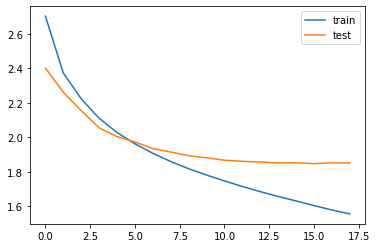

In [153]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<br>

### 인퍼런스 모델 구현하기

In [155]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [156]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [157]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어주세요.

In [158]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

<br>

### 모델 테스트하기

In [160]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [161]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : never mind amazon price less target deciding factor ordering thru amazon freshness gum factor keep coming back site product 
실제 요약 : it is super fresh 
예측 요약 :  great product


원문 : hooked company tea twenty years ago york england good strong lovely colored rich tasting brew tea snob like weak go find something else 
실제 요약 : the best tea ever 
예측 요약 :  great tea


원문 : reviews read warned many one type box true case box nice variety teas couple kind expecting satisfied transaction 
실제 요약 : nice variety 
예측 요약 :  not as good as the


원문 : using coffee several years quite satisfied decaf rich satisfying robust taste early morning one best decaf coffees tasted 
실제 요약 : lavazza decaf espresso ground coffee 
예측 요약 :  great decaf


원문 : excellent health conscious snack food calories per serving new flavor appeal one favorites interesting change pace 
실제 요약 : interesting 
예측 요약 :  great snack


원문 : daughter loved chebe pizza mix would open package would smell oregano heaven ordered obvi

예측 요약 :  good coffee


원문 : first time cooked tasted bad cooked minutes tasted like knew buy 
실제 요약 : great tasting if cooked long enough 
예측 요약 :  not bad


원문 : remember taste punch mixed ginger ale black cherry flavor tastes lot like love flavor love calories get ounce serving switch exception label also mention caffeine tastes yummy going help anyone lose weight 
실제 요약 : tasty but full of calories 
예측 요약 :  delicious


원문 : ordered breakfast blend last three years last order received amazon awful bitter burnt undrinkable favorite coffee 
실제 요약 : yuck 
예측 요약 :  weak coffee


원문 : individual packets make small cup hot milk wonderful treat deep dark chocolate flavor makes feel like enjoying stay expensive bed breakfast recommend using whole milk give rich mouth feel although way make good 
실제 요약 : delicious treat 
예측 요약 :  great for


원문 : product organic nothing label says organic repeat product organic words since repeated words count 
실제 요약 : not organic 
예측 요약 :  not as good as




<br>

---

<br><br>

<br>

### 추출적 요약 해보기

<br>

**패키지 설치<br>**

---

In [162]:
pip list | grep summa

summa                         1.2.0
Note: you may need to restart the kernel to use updated packages.


<br>

**데이터 다운로드하기<br>**

---

In [163]:
import requests
from summa.summarizer import summarize

In [165]:
# 매트릭스 시놉시스를 다운로드 해주세요.

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [166]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

<br>

**Summaraize 사용하기<br>**

---

#### Summa의 summarize()의 인자로 사용되는 값

> text (str) : 요약할 테스트.<br>
> ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값<br>
> words (int or None, optional) – 출력에 포함할 단어 수.<br>
> 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.<br>
> split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [167]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [168]:
# 만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 돼요.

print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [169]:
# 단어의 수로 요약문의 크기를 조절할 수도 있어요. 단어를 50개만 선택하도록 해보세요.

print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
